# Lecture 11 時系列分析

- 「データサイエンス教本：橋本」とは少し、式の形とかアプローチが異なることに注意
  

【注意】satatsmodelsを最新に上げる必要がある。ランタイムを再起動する必要あり

In [1]:
pip install statsmodels --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import io
import requests
import statsmodels.api as sm


## 対数差分変換

金融の分野では、元の価格推移のデータを対数変換したのち差分変換する対数差分変換がしばしば行われ、変化後のデータは「対数収益率」とよばれます。 対数収益率を用いることには、「100円の銘柄が1円値上がりする」ことと「1000円の銘柄が1円値上がりする」ことの不平等さを解消できることなど、様々なメリットがあります。

In [3]:

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
df = pd.read_csv(io.StringIO(stream.decode('utf-8')))
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<Axes: >

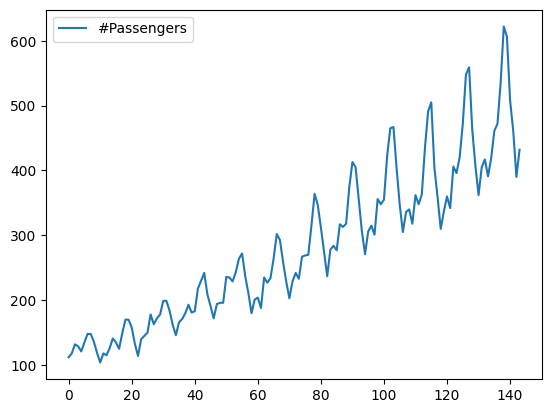

In [4]:
df.plot()

##### 差分変換

差分変換についてですが、pandasのdiff()メソッドを使うことができます。 引数periodsは差分を取るラグを表しています。 実行結果を見ると、AirPassengersのトレンドは除去され、平均に関する非定常性を解消できたことが伺えます。

<Axes: >

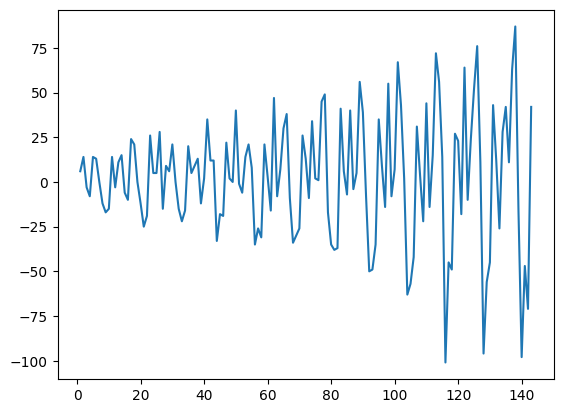

In [5]:
Passengers_diff = df["#Passengers"].diff(periods = 1)
Passengers_diff.plot()

##### 対数変換
次に対数変換を行ってみましょう。 対数をとるには数値計算モジュールnumpyのlog()を使います。 なお、対数の底はネイピア数e です。 対数変換後の図ともとの図を見比べると、トレンドに比例したバラツキの増加が解消されたことがわかります。

In [6]:
Passengers_log = np.log(df["#Passengers"])
Passengers_log.head()

0    4.718499
1    4.770685
2    4.882802
3    4.859812
4    4.795791
Name: #Passengers, dtype: float64

<Axes: >

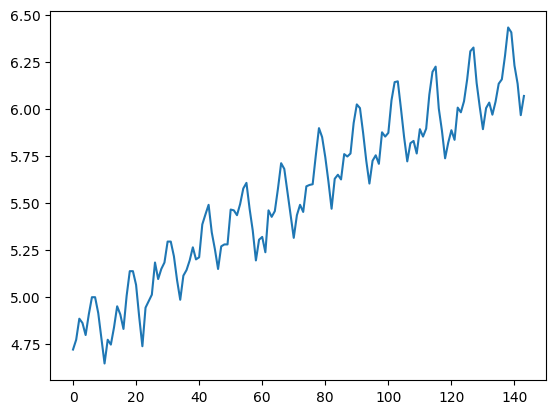

In [7]:
Passengers_log.plot()

##### 対数変換と差分変換を組み合わせた対数差分
対数変換と差分変換を組み合わせた対数差分の例を示します。 先ほど作成したPassengers_logを再利用し、差分をとってみましょう。 周期性が残っているものの、定常性の条件のうち、平均と分散に関するものが解消できたことが伺えます。

<Axes: >

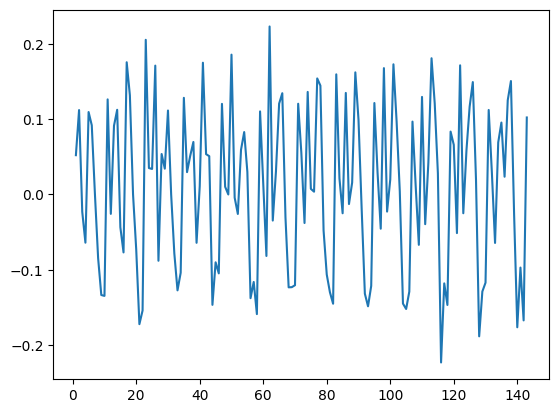

In [8]:
Passengers_log_diff = Passengers_log.diff(periods = 1)
Passengers_log_diff.plot()

##### 周期差分
周期を取り除くために、Passengers_logに対しperiods = 12として季節差分を行ってみましょう。 季節周期がなくなり、前年差が残ったことになります。

<Axes: >

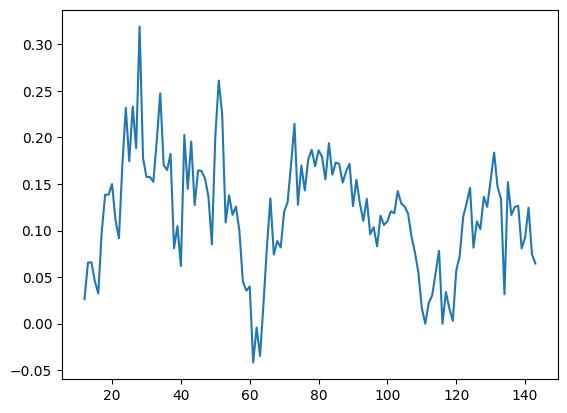

In [9]:
Passengers_sdiff = Passengers_log.diff(periods = 12)
Passengers_sdiff.plot()

さらにもう一度ラグ1の差分をとると、見た目が大分定常らしくなりました

<Axes: >

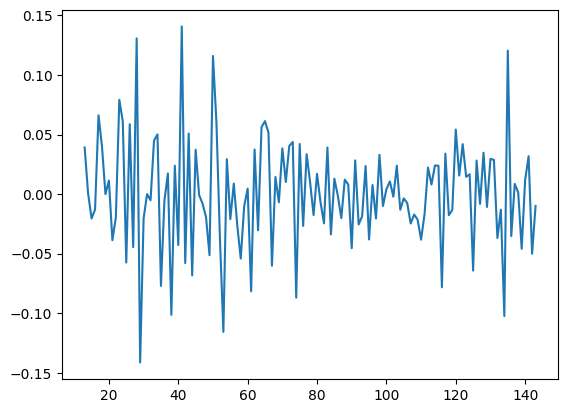

In [10]:
Passengers_sdiff2 = Passengers_sdiff.diff()
Passengers_sdiff2.plot()

## Time Series Data

https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Time%20Series%20Data.ipynb

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()

Ice Cream Production Data

In [12]:
#read data
url='https://raw.githubusercontent.com/miwamasa/DataScience2024/main/notebooks/data/ice_cream.csv'
df_ice_cream = pd.read_csv(url)

HTTPError: HTTP Error 404: Not Found

In [ ]:
df_ice_cream.head()

コラム名を、わかりやすい名称に変更

In [ ]:
#rename columns to something more understandable
df_ice_cream.rename(columns={'DATE':'date', 'IPN31152N':'production'}, inplace=True)

dataコラムを、datetime型に変換（スライスなどが簡単になる）

In [ ]:
#convert date column to datetime type
df_ice_cream['date'] = pd.to_datetime(df_ice_cream.date)

dateをインデクスに設定

In [ ]:
#set date as index
df_ice_cream.set_index('date', inplace=True)

datetime型を使った、スライスが可能になり、2010-1-1以降のデータを得る

In [ ]:
#just get data from 2010 onwards
start_date = pd.to_datetime('2010-01-01')
df_ice_cream = df_ice_cream[start_date:]

In [ ]:
#show result
df_ice_cream.head()

In [ ]:

plt.figure(figsize=(10,4))
plt.plot(df_ice_cream.production)
plt.title('Ice Cream Production over Time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

### ACF
ACFを測ってみる、長期の傾向を測る。

In [ ]:
acf_plot = plot_acf(df_ice_cream.production, lags=100)

長期の傾向が、減衰しているようなので、ここはARモデルを採用するほうがよさそうだ。
Based on decaying ACF, we are likely dealing with an Auto Regressive process


ではARのラグは何を指定すればよいのか？そこでPACFを検査する

### PACF

In [ ]:
pacf_plot = plot_pacf(df_ice_cream.production)

PACFの結果から、モデルとしては、ARモデルで、ラグが lags=1,2,3,10,13 のモデルが良いと思われる。

## 季節性分解
季節性を分解してみましょう

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import io
import requests
import statsmodels.api as sm

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
passengers = content['#Passengers']

In [ ]:
pd_content = content.copy()
pd_content['Month'] = pd.to_datetime(pd_content['Month'], infer_datetime_format=True)
pd_content.index = pd_content.Month

In [ ]:
pd_content['#Passengers'].plot()

In [ ]:
df_passenger = pd.DataFrame(content['#Passengers'].values.astype(int), 
 #                           pd.DatetimeIndex(start='1949-01',
                            pd.date_range(start='1949-01',
                                             periods=len(content['#Passengers']), 
                                             freq='M'))

In [ ]:
df_passenger.head()

### 加法モデルに基づく季節性分解

In [ ]:
#ts = sm.tsa.seasonal_decompose(df_passenger.values, freq=12)
ts = sm.tsa.seasonal_decompose(df_passenger, model='additive',extrapolate_trend='freq')

In [ ]:
ts.plot();

In [ ]:
# 季節変動
plt.plot(ts.seasonal)

### 乗法モデルによる季節分解

In [ ]:
ts2 = sm.tsa.seasonal_decompose(df_passenger, model='multiplicative',extrapolate_trend='freq')

In [ ]:
ts2.plot();

## 移動平均
- 　データは以下から入手
- https://www.mizuhobank.co.jp/market/index.html

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
# エクセル向けデータで文字コードshift-jis、最初の行は日本語のコラム名なので、飛ばして1行目の英語のコラム名から読む
df_historical = pd.read_csv("https://raw.githubusercontent.com/miwamasa/DataScience2024/main/notebooks/data/m_quote.csv",encoding="shift-jis",header=1)
df_historical.head()

In [ ]:
df_historical.USD.plot()

In [ ]:
df_historical.USD.plot()
df_historical.USD.rolling(window=24).mean().plot(style='--')
df_historical.USD.rolling(48).mean().plot(style=':')

## 時間依存性の発見

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import io
import requests

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))
passengers = content['#Passengers']

In [ ]:
import statsmodels.api as sm

# 自己相関
p_acf = sm.tsa.stattools.acf(passengers)

# 偏自己相関
p_pacf = sm.tsa.stattools.pacf(passengers, method='ols')
p_acf, p_pacf

In [ ]:
sm.graphics.tsa.plot_acf(passengers, lags=40);

In [ ]:
sm.graphics.tsa.plot_pacf(passengers, lags=35);

### 定常性、
df_historical.USDをまた使います

In [ ]:
df_historical.USD.plot()

In [ ]:
df_logdiff_USD = (1 + df_historical.USD.pct_change()).apply(np.log)

In [ ]:
df_historical.USD.div(df_historical.USD.shift(1)) - 1

In [ ]:
df_historical.USD.pct_change()

In [ ]:
df_logdiff_USD.plot()

## ARモデル

 出典：[島田]島田：時系列解析、共立出版

2003年から2013年までの月ごとのアイスクリームの家庭平均消費額データを使う

ARモデルは定常時系列d－多にした適用できないため、定常過程であるかを検定(ADF検定)しながら、階差をとりつつ、定常にした上でARによりモデル化する。

In [ ]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa import ar_model

In [ ]:
# アイスクリーム消費データ
df_ice = pd.read_csv('https://raw.githubusercontent.com/miwamasa/DataScience2024/main/notebooks/data/icecream2.csv')

In [ ]:
# 月ごとの家庭平均消費額のみを抽出し
# インデックスを2003年1月からの月ごとにする
y = pd.Series(df_ice.expenditure_yen.values, 
              index=pd.date_range('2016-1', periods=len(df_ice), freq='M'))
y.plot()

ここで、adfuller()関数を使って、ADF検定を行う、

regression=回帰モデルの定数とトレンドを指定する。
- regression = 'c'    定数のみ
- regression = 'ct'    定数とトレンド
- regression = 'ctt'    定数と１次、２次のトレンド
- regression = 'nt'    定数もトレンドもなし

回帰モデルの設定の元、もっともPt値の低くなった組合せを返す。

返り値：2番目がP値である。

- adf
  - ADF検定の統計量
- pvalue
  - 検定のP値
- usedlag
-   モデルに採用されたラグの値
- nobs
  - 回帰に使われたデータの個数
- critical values
  - 検定の1,5,10%点の値
- icbest
  - autolagがNoneでない場合、情報量の最大値を返す。
- resstore
  - 検定と回帰の結果のインスタンス

In [ ]:
# トレンド項あり(2次まで)，定数項ありの場合
ctt = stattools.adfuller(y[:50], regression="ctt")
# トレンド項あり(1次)，定数項ありの場合
ct = stattools.adfuller(y[:50], regression="ct")
# トレンド項なし，定数項ありの場合
c = stattools.adfuller(y[:50], regression="c")
# トレンド項なし，定数項なしの場合
nc = stattools.adfuller(y[:50], regression="n")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

いづれの場合もP値が高く、単位根過程であることが棄却された。

帰無仮説（時系列は非定常である）が棄却できなかったということ。

pandasのdiff()関数を使い、1次階差をとってみると、トレンドが消えたように見える

diffをとると端にNAが生じるので、dropna()していることに注意。

In [ ]:
y_diff = y.diff()[:50].dropna()
y_diff.plot()

で0タの数は減っている。

In [ ]:
y_diff.count()

再び単位根の検定を行う。

In [ ]:
ctt = stattools.adfuller(y_diff, regression="ctt")
ct = stattools.adfuller(y_diff, regression="ct")
c = stattools.adfuller(y_diff, regression="c")
nc = stattools.adfuller(y_diff, regression="n")
print('ctt:')
print(ctt)
print('ct:')
print(ct)
print('c:')
print(c)
print('nc:')
print(nc)

どの回帰モデルをつかっても、P値が十分低い、つまり単位根があるといえる


帰無仮説（時系列は非定常である）は棄却され、定常であるということ。

In [ ]:
y_diff.plot()

In [ ]:
# 偏自己相関
tsaplots.plot_pacf(y_diff, lags=15);

lagを11までときめて実行

In [ ]:
model = ar_model.AutoReg(y_diff,lags=11)
#model = ar_model.AR(y_diff,lags=11)
result=model.fit()
print(result.summary())

In [ ]:
result.params

In [ ]:
res11= result.resid
plt.bar(range(len(res11)),res11)

In [ ]:
# 偏自己相関
tsaplots.plot_pacf(res11, lags=12);

In [ ]:
result.fittedvalues

In [ ]:
y_pred=result.predict()

In [ ]:
y_diff.plot()
y_pred.plot()

In [ ]:
#model = ar_model.AR(y_diff)
for i in range(20):
    results = ar_model.AutoReg(y_diff,lags=i+1).fit() 
    print('lag = ', i+1, 'aic : ', results.aic)

In [ ]:
#model = ar_model.AutoReg(y_diff)
#for i in range(20):
#    results = model.fit(maxlag=i+1)
#    print('lag = ', i+1, 'aic : ', results.aic)

ここから、これを参考　https://note.com/yiida/n/n6210246ec5b0

In [ ]:
# 次数の推定
mod = ar_model.ar_select_order(y_diff, glob=True,maxlag=13)
mod.ar_lags

In [ ]:
# lags を 1 から 12 に変更
ar_model_lag12 = ar_model.AutoReg(y_diff, lags=12)
# モデルの当てはめ
ar_model_lag12 = ar_model_lag12.fit()
# 予測
predict_lag12 = ar_model_lag12.predict()

In [ ]:
y_diff.plot()
predict_lag12.plot()

## ARMAモデル

In [ ]:
%matplotlib inline
import numpy as np
np.random.seed(555)
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

ここｋら、
https://analytics-note.xyz/time-series/statsmodels-arma/

In [ ]:
# 次数の推定
print(sm.tsa.arma_order_select_ic(y_diff, max_ar=5, max_ma=5, ic='aic'))

'aic_min_order': (4, 4)}　とでているのでARMA(4,4)でモデル化してみる

注ここでは、ARIMA(4,0,4)で代替

In [ ]:
# ARMAモデルの作成と推定
arma_model = sm.tsa.ARIMA(y_diff, order=(4, 0,4))
result = arma_model.fit()

In [ ]:
#結果の表示
print(result.summary())

In [ ]:
y_pred=result.predict()
y_diff.plot()
y_pred.plot()

なんとなく季節性に弱い感じです。

## ホワイトノイズ

In [ ]:
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k')

In [ ]:
# Declare
white_noise = np.random.randn(1000)

# Plot
plt.title('White Noise Plot', size=20)
plt.plot(np.arange(len(white_noise)), white_noise);

In [ ]:
# Split into an arbitraty number of chunks
white_noise_chunks = np.split(white_noise, 20)
means, stds = [], []

# Get the mean and std values for every chunk
for chunk in white_noise_chunks:
    means.append(np.mean(chunk))
    stds.append(np.std(chunk))
    
    
# Plot
plt.title('White Noise Mean and Standard Deviation Comparison', size=20)
plt.plot(np.arange(len(means)), [white_noise.mean()] * len(means), label='Global mean', lw=1.5)
plt.scatter(x=np.arange(len(means)), y=means, label='Mean', s=100)
plt.plot(np.arange(len(stds)), [white_noise.std()] * len(stds), label='Global std', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange', s=100)
plt.legend()

## ARIMAによる解析の例


In [ ]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa import stattools
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


In [ ]:
import requests
import io

# 月ごとの飛行機の乗客数データ
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
content = pd.read_csv(io.StringIO(stream.decode('utf-8')))

In [ ]:
df_content = content.copy()
df_content['Month'] = pd.to_datetime(df_content['Month'], 
                                     infer_datetime_format=True)
y = pd.Series(df_content["#Passengers"].values, index=df_content['Month'])
y = y.astype('f')
y.plot()

In [ ]:
len(y)

In [ ]:
# yは上のコードで取得した月ごとの旅客機の乗客数データ
y120 = y[:120]

In [ ]:
y120.values

In [ ]:
# 階差をとらないモデル(p=3,d=0,q=2)
model_d0 =sm.tsa.arima.ARIMA(y120.values, order=(3, 0, 2))
results_d0 = model_d0.fit()
res_d0 = results_d0.resid
# 残差の出力
plt.bar(range(len(res_d0[1:])), res_d0[1:])

In [ ]:
len(res_d0[1:])

In [ ]:
# 偏自己相関
tsaplots.plot_pacf(res_d0[1:], lags=20);

In [ ]:
# 将来予測
# トレンドが捉えられていない
# 循環変動も捉えられていない

# 原系列の表示
plt.plot(y.values, label='observation')
# インサンプル（学習に使ったサンプルデータ）と
# ARIMA(3, 0, 2)による予測値を含めた系列の表示
# ARモデルの時とpredictの挙動が異なるので要注意
plt.plot(results_d0.predict(1, len(y)), 
         '--', label='forecast')
plt.legend()

In [ ]:
# 階差をとらないモデル(p=4,d=1,q=1)
model_d0 =sm.tsa.arima.ARIMA(y120.values, order=(4, 1, 1))
results_d0 = model_d0.fit()
res_d0 = results_d0.resid
# 残差の出力
plt.bar(range(len(res_d0[1:])), res_d0[1:])

In [ ]:
# 偏自己相関
tsaplots.plot_pacf(res_d0[1:], lags=28);

In [ ]:
# 将来予測
# トレンドが捉えられていない
# 循環変動も捉えられていない

# 原系列の表示
plt.plot(y.values, label='observation')
# インサンプル（学習に使ったサンプルデータ）と
# ARIMA(3, 0, 2)による予測値を含めた系列の表示
# ARモデルの時とpredictの挙動が異なるので要注意
plt.plot(results_d0.predict(1, len(y)), 
         '--', label='forecast')
plt.legend()

## SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
p, d, q, sp, sd, sq = 2, 1, 2, 1, 1, 1
seasonal = 12

# SARIMAX(p=2,d=1,q=2; P=1,D=1,Q=1,s=12)モデルの当てはめ
result = SARIMAX(
    y120, order=(p,d,q), 
    seasonal_order=(sp,sd,sq,seasonal), 
    enforce_stationarity = False, 
    enforce_invertibility = False
).fit()
# 結果確認
print(result.summary())

In [ ]:
# 残差の抽出
res = result.resid
# 残差の出力
plt.bar(range(len(res)), res)

In [ ]:
# 偏自己相関
tsaplots.plot_pacf(res, lags=29);
# ランダムウォーク過程のため自己相関はないことが確認できた

In [ ]:
# 将来予測
plt.plot(y.values, label="observation")
plt.plot(np.hstack([y120[0], 
                    result.fittedvalues[1:], 
                    result.forecast(24)]), 
         '--', label="forecast")

### VARモデル

2変量のVARモデルにしたがうデータから、Pythonを使ってモデルの係数を推定する方法を紹介します。
答え合わせをしたいので、使うデータは特定のVARモデルから生成します。

https://analytics-note.xyz/time-series/statsmodels-var-fit/


$$

\left\{\begin{matrix}\
y_{1t} &=& 2+ 0.5 y_{1,t-1}+ 0.4 y_{2,t-1}+\varepsilon_{1t},\\\
y_{2t} &=& -3 + 0.6 y_{1,t-1}+ 0.3 y_{2,t-1}+\varepsilon_{2t}\
\end{matrix}\

\right.\

\left(\begin{matrix}\varepsilon_{1t}\\\varepsilon_{2t}\end{matrix}\right)\sim W.N.(\mathbf{\Sigma})

$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mean = np.array([0, 0])
cov = np.array([[4, 1.2], [1.2, 1]])

# 少し長めの系列でデータを生成する。
data = np.zeros([110, 2])
epsilons = np.random.multivariate_normal(mean, cov, size=110)
print(np.cov(epsilons, rowvar=False))
"""
[[3.96508657 1.1917421 ]
 [1.1917421  1.01758275]]
"""

for i in range(1, 110):
    data[i, 0] = 2 + 0.5*data[i-1, 0] + 0.4*data[i-1, 1] + epsilons[i, 0]
    data[i, 1] = -3 + 0.6*data[i-1, 0] + 0.3*data[i-1, 1] + epsilons[i, 1]

# 初めの10項を切り捨てる
data = data[10:]
# data.shape == (100, 2)

fig = plt.figure(figsize=(12, 5), facecolor="w")
ax = fig.add_subplot(111)
ax.plot(data[:, 0], label="$y_1$")
ax.plot(data[:, 1], label="$y_2$")
ax.set_title("サンプルデータ")
plt.legend()
plt.show()

ここから、VARモデルに当てはめます。

In [ ]:
data

In [ ]:
from statsmodels.tsa.api import VAR
model = VAR(data)
result = model.fit(maxlags=1)
result.summary()

In [ ]:
result.params

VARモデルに当てはめた結果

$$
\left\{\begin{matrix}\

y_{1t} &=& 2.42+ 0.42 y_{1,t-1}+ 0.43 y_{2,t-1}\\\

y_{2t} &=& -3.01 + 0.61 y_{1,t-1}+ 0.31 y_{2,t-1}\

\end{matrix}\

\right.\
$$